# LOFAR2.0 Station SDP Firmware quantization model

Author: Eric Kooistra, Aug - Dec 2022

Purpose: Model the expected signal levels in the SDP firmware and clarify calculations in [1].

Usage:
* On command line start: > jupyter notebook
* In browser open the ipynb and run it

References:

1. https://support.astron.nl/confluence/display/L2M/L4+SDPFW+Decision%3A+LOFAR2.0+SDP+Firmware+Quantization+Model
2. Understanding digital signal processing, R.G. Lyons

In [1]:
import numpy as np
import matplotlib.pyplot as plt

dpi = 254  # 10 dots per mm

# 1 SDP Parameters

In [2]:
# General
N_complex = 2
N_sidebands = 2

# SDP
N_fft = 1024  # number of time points, number of frequency bins
N_sub = N_fft / N_sidebands  # number of subbands, DC and positive frequeny bins
f_adc = 200e6 # Hz
f_sub = f_adc / N_fft
T_int = 1 # s
N_int_adc = f_adc * T_int
N_int_sub = f_sub * T_int
N_int_sub_bits = np.log2(N_int_sub)
N_int_sub_dB = 10 * np.log2(N_int_sub_bits)

print(f"N_int_adc = {N_int_adc:.0f}")
print(f"N_int_sub = {N_int_sub:.1f}")
print(f"log2(N_int_sub) = {N_int_sub_bits:4.1f} bits = {N_int_sub_dB:4.1f} dB")

N_int_adc = 200000000
N_int_sub = 195312.5
log2(N_int_sub) = 17.6 bits = 41.4 dB


In [3]:
# Signal data widths and full scale
W_adc = 14
W_subband = 18
W_crosslet = 16
W_beamlet_sum = 18
W_beamlet = 8
W_statistic = 64
FS = 2**(W_adc - 1)  # full scale
sigma_fs_sine = FS / np.sqrt(2)

print("FS =", FS)
print(f"sigma_fs_sine = {sigma_fs_sine:.1f}")

FS = 8192
sigma_fs_sine = 5792.6


In [4]:
# Widths of coefficients and weights
W_fir_coef = 16
W_sub_weight = 16
W_sub_weight_fraction = 13
W_sub_weight_magnitude = W_sub_weight - W_sub_weight_fraction - 1
W_bf_weight = 16
W_bf_weight_fraction = 14
W_bf_weight_magnitude = W_bf_weight - W_bf_weight_fraction -1
W_beamlet_scale = 16
W_beamlet_scale_fraction = 15
W_beamlet_scale_magnitude = W_beamlet_scale - W_beamlet_scale_fraction
Unit_sub_weight = 2**W_sub_weight_fraction
Unit_bf_weight = 2**W_bf_weight_fraction
Unit_beamlet_scale = 2**W_beamlet_scale_fraction

print("Unit_sub_weight =", Unit_sub_weight)
print("Unit_bf_weight =", Unit_bf_weight)
print("Unit_beamlet_scale =", Unit_beamlet_scale)

Unit_sub_weight = 8192
Unit_bf_weight = 16384
Unit_beamlet_scale = 32768


## 1.1 Subband gain factor

In [5]:
# Gain factor between subband level and signal input level in the subband filterbank (F_sub)
# . for coherent WG sine based on amplitude
# . for white noise based on std

# . FIR filter DC gain
G_fir_dc = 0.994817  # actual DC gain of FIR filter in LOFAR
G_fir_dc = 1

# DFT gain for real input dc, sine and noise
G_fft_real_input_dc = 1  # coherent, one bin
G_fft_real_input_sine = 1 / N_sidebands  # coherent, so proportional to 1/N
G_fft_real_input_noise = 1 / np.sqrt(N_fft)  # incoherent, so proportional to 1/sqrt(N)

# . Signal level bit growth to accomodate processing gain of FFT
W_fft_proc = np.log2(np.sqrt(N_fft))

# . Subband equalizer (E_sub)
subband_weight_gain = 1.0
subband_weight_phase = 0
subband_weight_re = int(subband_weight_gain * Unit_sub_weight * np.cos(subband_weight_phase))
subband_weight_im = int(subband_weight_gain * Unit_sub_weight * np.sin(subband_weight_phase))

print(f"subband_weight_gain = {subband_weight_gain} (Unit_sub_weight = {Unit_sub_weight})")
print(f"subband_weight_phase = {subband_weight_phase}")
print(f"subband_weight_re = {subband_weight_re:d}")
print(f"subband_weight_im = {subband_weight_im:d}")
print()

# Expected factor from real signal input amplitude to subband amplitude
G_subband_sine = G_fir_dc * G_fft_real_input_sine * 2**W_fft_proc * subband_weight_gain

print("Coherent WG sine input:")
print(f"  G_subband_sine = {G_fir_dc} * {G_fft_real_input_sine} * 2**{W_fft_proc} * {subband_weight_gain} \
= {G_subband_sine} = {np.log2(G_subband_sine):.2f} bits")
print("  . G_fir_dc =", G_fir_dc)
print("  . G_fft_real_input_sine =", G_fft_real_input_sine, "=", 1 / N_sidebands)
print("  . W_fft_proc =", W_fft_proc)
print("  . subband_weight_gain =", subband_weight_gain)
print()

# Expected factor from real signal input white noise sigma to subband noise sigma
G_subband_noise = G_fir_dc * G_fft_real_input_noise * 2**W_fft_proc * subband_weight_gain

print("Incoherent white noise input:")
print(f"  G_subband_noise = {G_fir_dc} * {G_fft_real_input_noise} * 2**{W_fft_proc} * {subband_weight_gain} \
= {G_subband_noise} = {np.log2(G_subband_noise):.2f} bits")
print("  . G_fir_dc =", G_fir_dc)
print("  . G_fft_real_input_noise =", G_fft_real_input_noise, "=", 1 / np.sqrt(N_fft))
print("  . W_fft_proc =", W_fft_proc)
print("  . subband_weight_gain =", subband_weight_gain)
print()


subband_weight_gain = 1.0 (Unit_sub_weight = 8192)
subband_weight_phase = 0
subband_weight_re = 8192
subband_weight_im = 0

Coherent WG sine input:
  G_subband_sine = 1 * 0.5 * 2**5.0 * 1.0 = 16.0 = 4.00 bits
  . G_fir_dc = 1
  . G_fft_real_input_sine = 0.5 = 0.5
  . W_fft_proc = 5.0
  . subband_weight_gain = 1.0

Incoherent white noise input:
  G_subband_noise = 1 * 0.03125 * 2**5.0 * 1.0 = 1.0 = 0.00 bits
  . G_fir_dc = 1
  . G_fft_real_input_noise = 0.03125 = 0.03125
  . W_fft_proc = 5.0
  . subband_weight_gain = 1.0



## 1.2 Beamlet gain factor

In [6]:
# Gain factor G_beamlet_sum between beamlet and signal input in the digital beamformer (BF)
# . coherent input is same signal (e.g. sine or noise) on all inputs
# . incoherent input is different signal (noise) on all inputs

# . Assume all N_ant use same BF weight
beamlet_weight_gain = 1.0
beamlet_weight_phase = 0
beamlet_weight_re = int(beamlet_weight_gain * Unit_bf_weight * np.cos(beamlet_weight_phase))
beamlet_weight_im = int(beamlet_weight_gain * Unit_bf_weight * np.sin(beamlet_weight_phase))

print("Same BF weight for all inputs:")
print(f". beamlet_weight_gain = {beamlet_weight_gain} (Unit_bf_weight = {Unit_bf_weight})")
print(f". beamlet_weight_phase = {beamlet_weight_phase}")
print(f". beamlet_weight_re = {beamlet_weight_re:d}")
print(f". beamlet_weight_im = {beamlet_weight_im:d}")
print()

# Use range of N_ant for number of signal inputs in the BF
N_ant_arr = np.array([1, 12, 24, 48, 96])
print(f"N_ant_arr = {N_ant_arr}")
print()      

# BF processing gain for N_ant coherent inputs and for N_ant incoherent inputs
bf_proc_coh = N_ant_arr
bf_proc_coh_bits = np.log2(bf_proc_coh)
bf_proc_incoh = np.sqrt(N_ant_arr)
bf_proc_incoh_bits = np.log2(bf_proc_incoh)

print("Gain from subband to beamlet:")
print()          
for ni, na in enumerate(N_ant_arr):
    print(f"  N_ant = {na:2d} : bf_proc_coh = {bf_proc_coh[ni]:5.2f} = {np.log2(bf_proc_coh[ni]):.1f} bits")
print()    
for ni, na in enumerate(N_ant_arr):
    print(f"  N_ant = {na:2d} : bf_proc_incoh = {bf_proc_incoh[ni]:5.2f} = {np.log2(bf_proc_incoh[ni]):.1f} bits")
print()

# Expected factor from real signal input amplitude to beamlet amplitude
G_beamlet_sum_sine = G_subband_sine * bf_proc_coh * beamlet_weight_gain

# Expected factor from real signal input sigma to beamlet sigma
G_beamlet_sum_noise = G_subband_noise * bf_proc_incoh * beamlet_weight_gain

print("Gain from signal input to beamlet:")
print()          
for ni, na in enumerate(N_ant_arr):
    print(f"  N_ant = {na:2d} : G_beamlet_sum_sine = {G_subband_sine:.2f} * " \
          f"{bf_proc_coh[ni]:5.2f} * {beamlet_weight_gain} " \
          f"= {G_beamlet_sum_sine[ni]:7.2f} = {np.log2(G_beamlet_sum_sine[ni]):.1f} bits")
print()          
for ni, na in enumerate(N_ant_arr):
    print(f"  N_ant = {na:2d} : G_beamlet_sum_noise = {G_subband_noise:.2f} * " \
          f"{bf_proc_incoh[ni]:5.2f} * {beamlet_weight_gain} " \
          f"= {G_beamlet_sum_noise[ni]:6.2f} = {np.log2(G_beamlet_sum_noise[ni]):.1f} bits")
print()

Same BF weight for all inputs:
. beamlet_weight_gain = 1.0 (Unit_bf_weight = 16384)
. beamlet_weight_phase = 0
. beamlet_weight_re = 16384
. beamlet_weight_im = 0

N_ant_arr = [ 1 12 24 48 96]

Gain from subband to beamlet:

  N_ant =  1 : bf_proc_coh =  1.00 = 0.0 bits
  N_ant = 12 : bf_proc_coh = 12.00 = 3.6 bits
  N_ant = 24 : bf_proc_coh = 24.00 = 4.6 bits
  N_ant = 48 : bf_proc_coh = 48.00 = 5.6 bits
  N_ant = 96 : bf_proc_coh = 96.00 = 6.6 bits

  N_ant =  1 : bf_proc_incoh =  1.00 = 0.0 bits
  N_ant = 12 : bf_proc_incoh =  3.46 = 1.8 bits
  N_ant = 24 : bf_proc_incoh =  4.90 = 2.3 bits
  N_ant = 48 : bf_proc_incoh =  6.93 = 2.8 bits
  N_ant = 96 : bf_proc_incoh =  9.80 = 3.3 bits

Gain from signal input to beamlet:

  N_ant =  1 : G_beamlet_sum_sine = 16.00 *  1.00 * 1.0 =   16.00 = 4.0 bits
  N_ant = 12 : G_beamlet_sum_sine = 16.00 * 12.00 * 1.0 =  192.00 = 7.6 bits
  N_ant = 24 : G_beamlet_sum_sine = 16.00 * 24.00 * 1.0 =  384.00 = 8.6 bits
  N_ant = 48 : G_beamlet_sum_sine = 

## 1.3 Maximum input level for beamlet_sum and BST

In [7]:
# Maximum coherent signal input amplitude
si_ampl_max = 2**(W_beamlet_sum - 1) / G_beamlet_sum_sine
for ni, na in enumerate(N_ant_arr):
    print(f"N_ant = {na:2d} : si_ampl_max = {si_ampl_max[ni] / FS:f} " \
          f"= {si_ampl_max[ni]:6.0f} = {np.log2(si_ampl_max[ni]):5.1f} bits")
print()

N_ant =  1 : si_ampl_max = 1.000000 =   8192 =  13.0 bits
N_ant = 12 : si_ampl_max = 0.083333 =    683 =   9.4 bits
N_ant = 24 : si_ampl_max = 0.041667 =    341 =   8.4 bits
N_ant = 48 : si_ampl_max = 0.020833 =    171 =   7.4 bits
N_ant = 96 : si_ampl_max = 0.010417 =     85 =   6.4 bits



In [8]:
# Maximum incoherent signal input sigma, for beamlet_sum_sigma * 4 = 2**(W_beamlet_sum - 1)
# Use 4 sigma to avoid overflow
ni_sigma_max = 2**(W_beamlet_sum - 1) / 4 / G_beamlet_sum_noise
for ni, na in enumerate(N_ant_arr):
    print(f"N_ant = {na:2d} : ni_sigma_max = {ni_sigma_max[ni] / FS:f} " \
          f"= {ni_sigma_max[ni]:6.0f} = {np.log2(ni_sigma_max[ni]):5.1f} bits")
print()

N_ant =  1 : ni_sigma_max = 4.000000 =  32768 =  15.0 bits
N_ant = 12 : ni_sigma_max = 1.154701 =   9459 =  13.2 bits
N_ant = 24 : ni_sigma_max = 0.816497 =   6689 =  12.7 bits
N_ant = 48 : ni_sigma_max = 0.577350 =   4730 =  12.2 bits
N_ant = 96 : ni_sigma_max = 0.408248 =   3344 =  11.7 bits



# 2 Quantization noise

## 2.1 dB full scale (dBFS)

In [9]:
# Bit
# . Each bit yields a factor 2 in voltage, so a factor 2**2 = 4 in power 
P_bit = 2**2
P_bit_dB = 10 * np.log10(P_bit)
print(f"P_bit_dB = {P_bit_dB:.2f} dB")

P_bit_dB = 6.02 dB


In [10]:
# Full scale (FS) sine
P_fs_sine = FS**2 / 2
P_fs_sine_dB = 10 * np.log10(P_fs_sine)
print(f"W_adc = {W_adc} bits")
print("FS =", FS)
print(f"sigma_fs_sine = {sigma_fs_sine:.1f} q")
print(f"P_fs_sine_dB = {P_fs_sine_dB:.2f} dB = {P_fs_sine_dB / P_bit_dB:.1f} bit")

W_adc = 14 bits
FS = 8192
sigma_fs_sine = 5792.6 q
P_fs_sine_dB = 75.26 dB = 12.5 bit


In [11]:
# dBFS: Signal level relative to FS sine
power_50dBFS = P_fs_sine_dB - 50  
sigma_50dBFS = 10**(power_50dBFS / 20)
sigma_50dBFS_bits = np.log2(sigma_50dBFS)
ampl_50dBFS = sigma_50dBFS * np.sqrt(2)

print(f"Power at -50dBFS = {power_50dBFS:.2f} dB corresponds to:")
print(f"  . sigma = {sigma_50dBFS:.1f} q (= {sigma_50dBFS_bits:.1f} bits)")
print(f"  . Noise range 3 sigma = +-{3 * sigma_50dBFS:.0f} q")
print(f"  . Sine with amplitude A = = sigma * sqrt(2) = {ampl_50dBFS:.1f} q")
print()

# Assume signal with sigma = 16 q is 4 bits noise
sigma_16q = 16
sigma_16q_bits = np.log2(sigma_16q)
power_16q = sigma_16q**2
power_16q_dB = 10 * np.log10(power_16q)
dBFS_16q = power_16q_dB - P_fs_sine_dB
print(f"sigma = {sigma_16q:.0f} q (= {sigma_16q_bits:.1f} bits) corresponds to:")
print(f"  . Power = {power_16q_dB:.2f} dB, so at {dBFS_16q:.1f} dBFS")
print(f"  . Noise range 3 sigma = +-{3 * sigma_16q:.0f} q")
print(f"  . Sine with amplitude A = sigma * sqrt(2) = {np.sqrt(2) * sigma_16q:.1f} q")


Power at -50dBFS = 25.26 dB corresponds to:
  . sigma = 18.3 q (= 4.2 bits)
  . Noise range 3 sigma = +-55 q
  . Sine with amplitude A = = sigma * sqrt(2) = 25.9 q

sigma = 16 q (= 4.0 bits) corresponds to:
  . Power = 24.08 dB, so at -51.2 dBFS
  . Noise range 3 sigma = +-48 q
  . Sine with amplitude A = sigma * sqrt(2) = 22.6 q


## 2.2 Signal to noise ratio (SNR)

In [12]:
# Quantization noise
# . The quantization noise power is q**2 * 1 / 12, so the standard deviation
#   of the quantization noise is q * sqrt(1 / 12) < q = one LSbit
# . The quantization noise power is at a level of -10.79 dB or -1.8 bit.
# . The 0 dB power level or 0 bit level corresponds to the power of one LSbit, so q**2 
P_quant = 1 / 12  # for W >> 1 [2]
P_quant_dB = 10 * np.log10(P_quant)
sigma_quant = np.sqrt(P_quant)
print()
print(f"P_quant = {P_quant:.6f}")
print(f"P_quant_dB = {P_quant_dB:.2f} dB = {P_quant_dB / P_bit_dB:.1f} bit")
print(f"sigma_quant = {sigma_quant:.2f} q")


P_quant = 0.083333
P_quant_dB = -10.79 dB = -1.8 bit
sigma_quant = 0.29 q


In [13]:
# Signal to noise ratio (SNR)
SNR = P_fs_sine / P_quant
SNR_dB = 10 * np.log10(SNR)

print()
print(f"SNR_dB = P_fs_sine_dB - P_quant_dB = {P_fs_sine_dB:.2f} - {P_quant_dB:.2f} = {SNR_dB:.2f} dB")


SNR_dB = P_fs_sine_dB - P_quant_dB = 75.26 - -10.79 = 86.05 dB


## 2.3 Impact of quantization on the system noise

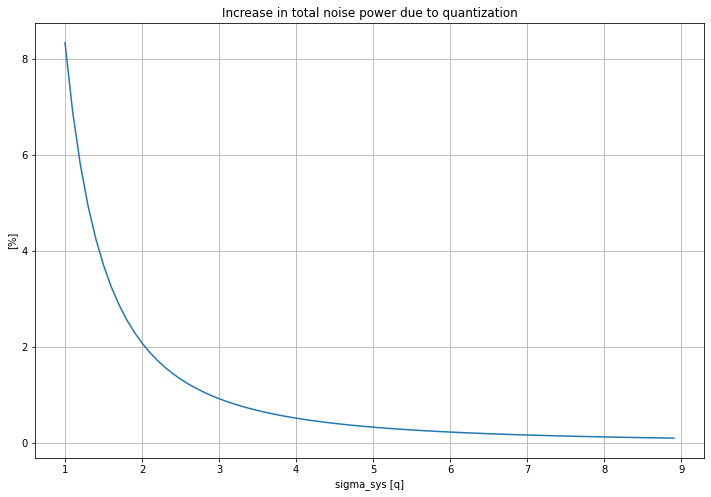

In [14]:
# Impact of quantization on the system noise
# The quantization noise has sigma_quant = 0.29 q, this increases the system noise.
# The system noise has sigma_sys = n * q. For n = 2 the quantization increases the
# total power by 2% (so sigma_sys increase by sqrt(2 %) is about 1 %).
step = 0.1
n = np.arange(1, 9, step)
sigma_sys = n  # = n * q, so sigma of n LSbits
P_sys = sigma_sys**2
P_tot = P_sys + P_quant
sigma_tot = np.sqrt(P_tot)

plt.figure(figsize=(12, 8))
plt.plot(n, (P_tot / P_sys - 1) * 100)
plt.title("Increase in total noise power due to quantization")
plt.xlabel("sigma_sys [q]")
plt.ylabel("[%]")
plt.grid()
plt.savefig('plots/lofar2_station_sdp_firmware_model_incr_sigma_sys.jpg', dpi=dpi)

# 3 Expected signal levels in the SDP FW

## 3.1 ADC Statistics (AST)

In [15]:
# Signal input power and DC level statistic for ADC / WG
si_sigma = sigma_fs_sine
si_sigma_bits = np.log2(si_sigma)
P_ast = (si_sigma)**2 * N_int_adc
P_ast_bits = np.log2(P_ast)
P_ast_dB = 10 * np.log10(P_ast)
print(f"SI sigma = {si_sigma:6.1f} q = {si_sigma_bits:4.1f} bits: P_ast = {P_ast:e} = {P_ast_dB:.1f} dB, \
uses {P_ast_bits:.1f} bits, is 0 dBFS = FS sine")

si_sigma = sigma_50dBFS
si_sigma_bits = np.log2(si_sigma)
P_ast = (si_sigma)**2 * N_int_adc
P_ast_bits = np.log2(P_ast)
P_ast_dB = 10 * np.log10(P_ast)
print(f"SI sigma = {si_sigma:6.1f} q = {si_sigma_bits:4.1f} bits: P_ast = {P_ast:e} = {P_ast_dB:.1f} dB, \
uses {P_ast_bits:.1f} bits, is -50 dBFS")

si_sigma = sigma_16q
si_sigma_bits = np.log2(si_sigma)
P_ast = (si_sigma)**2 * N_int_adc
P_ast_bits = np.log2(P_ast)
P_ast_dB = 10 * np.log10(P_ast)
print(f"SI sigma = {si_sigma:6.1f} q = {si_sigma_bits:4.1f} bits: P_ast = {P_ast:e} = {P_ast_dB:.1f} dB, \
uses {P_ast_bits:.1f} bits, is {dBFS_16q:.1f} dBFS")

SI sigma = 5792.6 q = 12.5 bits: P_ast = 6.710886e+15 = 158.3 dB, uses 52.6 bits, is 0 dBFS = FS sine
SI sigma =   18.3 q =  4.2 bits: P_ast = 6.710886e+10 = 108.3 dB, uses 36.0 bits, is -50 dBFS
SI sigma =   16.0 q =  4.0 bits: P_ast = 5.120000e+10 = 107.1 dB, uses 35.6 bits, is -51.2 dBFS


From measured P_ast and DC_ast to signal input sigma in q units:

* si_rms = sqrt(P_ast / N_int_adc)
* si_mean = DC_ast / N_int_adc
* si_sigma = sqrt(si_rms^2 - si_mean^2)

## 3.2 Subband statistics (SST)

For a complex signal (like subbands and beamlets), assume mean complex = 0 so rms = std and power = var (= std^2):

* power complex = power real + power imag = (std real)^2 + (std imag)^2
* power real = power imag = power complex / 2
* std real = std imag = std complex / sqrt(2)
* std complex = sqrt(power complex)
* ampl real = ampl imag = std complex = std real * sqrt(2) = std imag * sqrt(2)

### 3.2.1 Coherent, narrow band,  sine input

In [16]:
# Subband level and SST level for coherent (WG sine) input
# . use ampl real = ampl imag = std complex = sqrt(power complex) to calculate SST for sine input
si_ampl_fs = FS
si_ampl_fs_bits = np.log2(si_ampl_fs)
si_sigma_fs = si_ampl_fs / np.sqrt(2)
si_sigma_fs_bits = np.log2(si_sigma_fs)
sub_ampl_fs = si_ampl_fs * G_subband_sine  # subband amplitude for FS signal input sine
sub_ampl_fs_bits = np.log2(sub_ampl_fs)
SST_fs = sub_ampl_fs**2 * N_int_sub
SST_fs_dB = 10 * np.log10(SST_fs)
SST_fs_bits = np.log2(SST_fs)

si_ampl_fs4 = FS / 4
si_ampl_fs4_bits = np.log2(si_ampl_fs4)
si_sigma_fs4 = si_ampl_fs4 / np.sqrt(2)
si_sigma_fs4_bits = np.log2(si_sigma_fs4)
sub_ampl_fs4 = si_ampl_fs4 * G_subband_sine  # subband amplitude for FS signal input sine
sub_ampl_fs4_bits = np.log2(sub_ampl_fs4)
SST_fs4 = sub_ampl_fs4**2 * N_int_sub
SST_fs4_dB = 10 * np.log10(SST_fs4)
SST_fs4_bits = np.log2(SST_fs4)

si_ampl_50dBFS = ampl_50dBFS
si_ampl_50dBFS_bits = np.log2(si_ampl_50dBFS)
si_sigma_50dBFS = sigma_50dBFS
si_sigma_50dBFS_bits = np.log2(si_sigma_50dBFS)
sub_ampl_50dBFS = si_ampl_50dBFS * G_subband_sine  # subband amplitude -50dBFS signal input sine
sub_ampl_50dBFS_bits = np.log2(sub_ampl_50dBFS)
SST_50dBFS = sub_ampl_50dBFS**2 * N_int_sub
SST_50dBFS_dB = 10 * np.log10(SST_50dBFS)
SST_50dBFS_bits = np.log2(SST_50dBFS)

si_ampl_s16q = sigma_16q * np.sqrt(2)
si_ampl_s16q_bits = np.log2(si_ampl_s16q)
si_sigma_s16q = sigma_16q
si_sigma_s16q_bits = np.log2(sigma_16q)  # = 16
sub_ampl_s16q = si_ampl_s16q * G_subband_sine  # subband amplitude for signal input sine with sigma = 16 q
sub_ampl_s16q_bits = np.log2(sub_ampl_s16q)
SST_s16q = sub_ampl_s16q**2 * N_int_sub
SST_s16q_dB = 10 * np.log10(SST_s16q)
SST_s16q_bits = np.log2(SST_s16q)

print("Coherent (WG sine) signal input level --> Expected subband level and SST level:")
print()
print("  si_ampl         si_sigma           sub_sigma =         SST")
print("                                      sub_ampl")
print("    value  #bits     value  #bits        value  #bits           value     dB  #bits")
print(f"{si_ampl_fs:9.1f} {si_ampl_fs_bits:6.1f} " \
      f"{si_sigma_fs:9.1f} {si_sigma_fs_bits:6.1f} " \
      f"{sub_ampl_fs:12.1f} {sub_ampl_fs_bits:6.1f} " \
      f"{SST_fs:15e} {SST_fs_dB:6.1f} {SST_fs_bits:6.1f}, "
      f"at 0 dBFS (= FS sine)")
print(f"{si_ampl_fs4:9.1f} {si_ampl_fs4_bits:6.1f} " \
      f"{si_sigma_fs4:9.1f} {si_sigma_fs4_bits:6.1f} " \
      f"{sub_ampl_fs4:12.1f} {sub_ampl_fs4_bits:6.1f} " \
      f"{SST_fs4:15e} {SST_fs4_dB:6.1f} {SST_fs4_bits:6.1f}, "
      f"at {20*np.log10(1 / 4**2):.1f} dBFS (= FS / 4)")
print(f"{si_ampl_50dBFS:9.1f} {si_ampl_50dBFS_bits:6.1f} " \
      f"{si_sigma_50dBFS:9.1f} {si_sigma_50dBFS_bits:6.1f} " \
      f"{sub_ampl_50dBFS:12.1f} {sub_ampl_50dBFS_bits:6.1f} " \
      f"{SST_50dBFS:15e} {SST_50dBFS_dB:6.1f} {SST_50dBFS_bits:6.1f}, "
      f"at -50 dBFS (= FS / {10**(50/20):.0f})")
print(f"{si_ampl_s16q:9.1f} {si_ampl_s16q_bits:6.1f} " \
      f"{si_sigma_s16q:9.1f} {si_sigma_s16q_bits:6.1f} " \
      f"{sub_ampl_s16q:12.1f} {sub_ampl_s16q_bits:6.1f} "\
      f"{SST_s16q:15e} {SST_s16q_dB:6.1f} {SST_s16q_bits:6.1f}, "\
      f"at {dBFS_16q:.1f} dBFS (= FS / {10**(-dBFS_16q/20):.0f})")

Coherent (WG sine) signal input level --> Expected subband level and SST level:

  si_ampl         si_sigma           sub_sigma =         SST
                                      sub_ampl
    value  #bits     value  #bits        value  #bits           value     dB  #bits
   8192.0   13.0    5792.6   12.5     131072.0   17.0    3.355443e+15  155.3   51.6, at 0 dBFS (= FS sine)
   2048.0   11.0    1448.2   10.5      32768.0   15.0    2.097152e+14  143.2   47.6, at -24.1 dBFS (= FS / 4)
     25.9    4.7      18.3    4.2        414.5    8.7    3.355443e+10  105.3   35.0, at -50 dBFS (= FS / 316)
     22.6    4.5      16.0    4.0        362.0    8.5    2.560000e+10  104.1   34.6, at -51.2 dBFS (= FS / 362)


### 3.2.2 Incoherent, wide band, noise input

In [17]:
# Subband level and SST level for incoherent white noise input
# . the signal input power is equally distributed over all N_sub subbands
# . use std complex to calculate SST for noise input
# . use std real = std imag = std complex / sqrt(2) = sqrt(power complex / 2) to calculate subband level

# si_std = FS / 4
ni_sigma_fs4 = FS / 4
ni_sigma_fs4_bits = np.log2(ni_sigma_fs4)
nsub_sigma_fs4 = ni_sigma_fs4 * G_subband_noise
nsub_sigma_fs4_bits = np.log2(nsub_sigma_fs4)
nsub_sigma_re_fs4 = nsub_sigma_fs4 / np.sqrt(N_complex)
nsub_sigma_re_fs4_bits = np.log2(nsub_sigma_re_fs4)
nSST_fs4 = nsub_sigma_fs4**2 * N_int_sub
nSST_fs4_dB = 10 * np.log10(nSST_fs4)
nSST_fs4_bits = np.log2(nSST_fs4)

# si_std = 16
ni_sigma_s16q = sigma_16q
ni_sigma_s16q_bits = np.log2(ni_sigma_s16q)  # = 16
nsub_sigma_s16q = ni_sigma_s16q * G_subband_noise
nsub_sigma_s16q_bits = np.log2(nsub_sigma_s16q)
nsub_sigma_re_s16q = nsub_sigma_s16q / np.sqrt(N_complex)
nsub_sigma_re_s16q_bits = np.log2(nsub_sigma_re_s16q)
nSST_s16q = nsub_sigma_s16q**2 * N_int_sub
nSST_s16q_dB = 10 * np.log10(nSST_s16q)
nSST_s16q_bits = np.log2(nSST_s16q)

print("Incoherent white noise input level --> Expected subband level and SST level:")
print()
print(" si_sigma         sub_sigma         sub_sigma_re =         SST")
print("                                    sub_sigma_im")
print("    value  #bits      value  #bits         value  #bits           value     dB  #bits")
print(f"{ni_sigma_fs4:9.1f} {ni_sigma_fs4_bits:6.1f} " \
      f"{nsub_sigma_fs4:10.1f} {nsub_sigma_fs4_bits:6.1f} " \
      f"{nsub_sigma_re_fs4:13.1f} {nsub_sigma_re_fs4_bits:6.1f} " \
      f"{nSST_fs4:15e} {nSST_fs4_dB:6.1f} {nSST_fs4_bits:6.1f}")
print(f"{ni_sigma_s16q:9.1f} {ni_sigma_s16q_bits:6.1f} " \
      f"{nsub_sigma_s16q:10.1f} {nsub_sigma_s16q_bits:6.1f} " \
      f"{nsub_sigma_re_s16q:13.1f} {nsub_sigma_re_s16q_bits:6.1f} " \
      f"{nSST_s16q:15e} {nSST_s16q_dB:6.1f} {nSST_s16q_bits:6.1f}, at {dBFS_16q:.1f} dBFS")

Incoherent white noise input level --> Expected subband level and SST level:

 si_sigma         sub_sigma         sub_sigma_re =         SST
                                    sub_sigma_im
    value  #bits      value  #bits         value  #bits           value     dB  #bits
   2048.0   11.0     2048.0   11.0        1448.2   10.5    8.192000e+11  119.1   39.6
     16.0    4.0       16.0    4.0          11.3    3.5    5.000000e+07   77.0   25.6, at -51.2 dBFS


Conclusion (for W_fft_proc = 5 bits):
* For FS sine input the subband amplitude is 17 bits, so including the sign bit this fits in W_subband = 18b. It does not fit all special test signals (e.g. first harmonic of FS square wave input).
* For XST the W_crosslet = 16b subband samples can only fit sine signal input <= 0.25 FS
* For sigma = FS / 4 white noise input the subband sigma uses 11 bits, so 10.5 bits for the subband real and imaginary parts. The 4 sigma just fits in FS and corresponds to 2 bits, so including the sign bit the 4 sigma range of the subband real and imag fits in 1 + 10.5 + 2 = 13.5 bits.

### 3.2.3 From SST level to input level

In [24]:
# From measured SST to SSTq in q^2 units and subband and signal input
# . depends on whether the input was a coherent sine like signal or a white noise like signal

# Fsub gain implementation factors
print(f"G_subband_sine = {G_subband_sine} = {np.log2(G_subband_sine)} bits")
print(f"G_subband_noise = {G_subband_noise} = {np.log2(G_subband_noise)} bits")
print()

# Coherent (WG sine) signal: from SST to subband amplitude and signal input amplitude in q units
sub_SST = SST_fs4  # SST in WG sine frequency subband for si_ampl = FS / 4 = 2048
si_ampl_exp = si_ampl_fs4

sub_power = sub_SST / N_int_sub
sub_ampl = np.sqrt(sub_power)   # ampl real = ampl imag = std complex = sqrt(power complex)
si_ampl = sub_ampl / G_subband_sine

print(f"sub_SST = {sub_SST:e} (= {SST_fs4_dB:5.1f} dB)")
print(f". sub_power = {sub_power}")
print(f". sub_ampl = {sub_ampl}")
print(f". si_ampl = {si_ampl} (si_ampl_exp = {si_ampl_exp}) = FS/4")
print()

# Incoherent white noise signal: from SST to subband sigma and signal input sigma in q units:
sub_SST = nSST_fs4  # SST in any subband for si_sigma = FS / 4 = 2048
si_sigma_exp = ni_sigma_fs4

sub_power = sub_SST / N_int_sub
sub_sigma = np.sqrt(sub_power)   # std complex = sqrt(power)
sub_sigma_re = sub_sigma / np.sqrt(N_complex)
sub_sigma_im = sub_sigma / np.sqrt(N_complex)
si_sigma = sub_sigma / G_subband_noise

print(f"sub_SST = {sub_SST:e} (= {nSST_fs4_dB:5.1f} dB)")
print(f". sub_power = {sub_power}")
print(f". sub_sigma = {sub_sigma}")
print(f". sub_sigma_re = {sub_sigma_re}")
print(f". sub_sigma_im = {sub_sigma_im}")
print(f". si_sigma = {si_sigma} (si_sigma_exp = {si_sigma_exp}) = FS/4")
print()

# SST in dB as function of input signal level
si_ampls_bits = np.arange(1, W_adc-1, 0.1)
si_ampls = 2**si_ampls_bits
si_sigmas = si_ampls / np.sqrt(2)
si_sub_ampls = si_ampls * G_subband_sine  # subband amplitude for signal input sine
si_SSTs = si_sub_ampls**2 * N_int_sub
si_SSTs_dB = 10 * np.log10(si_SSTs)

ni_sigmas_bits = np.arange(1, W_adc-1, 0.1)
ni_sigmas = 2**ni_sigmas_bits
ni_sub_sigmas = ni_sigmas * G_subband_noise
ni_SSTs = ni_sub_sigmas**2 * N_int_sub
ni_SSTs_dB = 10 * np.log10(ni_SSTs)

plt.figure(figsize=(12, 8))
plt.plot(si_ampls_bits, si_SSTs_dB, 'r', ni_sigmas_bits, ni_SSTs_dB, 'b')
plt.title(f"SST as function of input sine amplitude and input noise sigma")
plt.xlabel("si_ampl, ni_sigma [bits]")
plt.ylabel("SST [dB]")
plt.legend(['si = sine input', 'ni = noise input'])
plt.grid()
plt.savefig('plots/lofar2_station_sdp_firmware_model_sst_db_si_bits.jpg', dpi=dpi)

diff_SST_bits = np.log2(G_subband_sine / G_subband_noise)
diff_SST_dB = 20 * np.log10(G_subband_sine / G_subband_noise)
print(f"The SST level for noise input is G_subband_sine / G_subband_noise = \
{G_subband_sine / G_subband_noise} = {diff_SST_bits:.1f} bit = {diff_SST_dB:.1f} dB \
below the SST level for sine input when ni_sigma = si_ampl. \
Note that typically ni_sigma < FS / 4 to avoid ADC input overflow.")

G_subband_sine = 16.0 = 4.0 bits
G_subband_noise = 1.0 = 0.0 bits

sub_SST = 2.097152e+14 (= 143.2 dB)
. sub_power = 1073741824.0
. sub_ampl = 32768.0
. si_ampl = 2048.0 (si_ampl_exp = 2048.0) = FS/4

sub_SST = 8.192000e+11 (= 119.1 dB)
. sub_power = 4194304.0
. sub_sigma = 2048.0
. sub_sigma_re = 1448.1546878700492
. sub_sigma_im = 1448.1546878700492
. si_sigma = 2048.0 (si_sigma_exp = 2048.0) = FS/4

The SST level for noise input is G_subband_sine / G_subband_noise = 16.0 = 4.0 bit = 24.1 dB below the SST level for sine input when ni_sigma = si_ampl. Note that typically ni_sigma < FS / 4 to avoid ADC input overflow.


## 3.3 Crosslet statistics (XST)

The crosslet statistics have W_crosslet = 16b, but use the same LSbit level as the subbands. The subbands have W_subband = 18b and the maximum subband sine amplitude is 17b (for W_fft_proc = 5 bits). Therefore the maximum sine input for no XST overflow is A = 0.25. If subband_weight = 1.0 then the auto correlations of the XST are equal to the SST. Hence the crosslets have the same sensitivity as the subbands, but less dynamic range.

## 3.4 Beamlet statistics (BST)

### 3.4.1 Coherent, narrow band,  sine input

In [19]:
# Digital beamformer (BF)
# . is a coherent beamformer = voltage beamformer
# . uses BF weights to form beamlets from sum of weighted subbands

# Beamlet_sum level and BST level for coherent (WG sine) input (similar as for SST)
beamlet_sum_ampl_fs = si_ampl_fs * G_beamlet_sum_sine  # beamlet amplitude for FS signal input sine
beamlet_sum_ampl_fs_bits = np.log2(beamlet_sum_ampl_fs)
BST_fs = beamlet_sum_ampl_fs**2 * N_int_sub
BST_fs_dB = 10 * np.log10(BST_fs)
BST_fs_bits = np.log2(BST_fs)

beamlet_sum_ampl_fs4 = si_ampl_fs4 * G_beamlet_sum_sine  # beamlet amplitude for FS signal input sine
beamlet_sum_ampl_fs4_bits = np.log2(beamlet_sum_ampl_fs4)
BST_fs4 = beamlet_sum_ampl_fs4**2 * N_int_sub
BST_fs4_dB = 10 * np.log10(BST_fs4)
BST_fs4_bits = np.log2(BST_fs4)

beamlet_sum_ampl_50dBFS = si_ampl_50dBFS * G_beamlet_sum_sine  # beamlet amplitude -50dBFS signal input sine
beamlet_sum_ampl_50dBFS_bits = np.log2(beamlet_sum_ampl_50dBFS)
BST_50dBFS = beamlet_sum_ampl_50dBFS**2 * N_int_sub
BST_50dBFS_dB = 10 * np.log10(BST_50dBFS)
BST_50dBFS_bits = np.log2(BST_50dBFS)

beamlet_sum_ampl_s16q = si_ampl_s16q * G_beamlet_sum_sine  # beamlet amplitude for signal input sine with sigma = 16 q
beamlet_sum_ampl_s16q_bits = np.log2(beamlet_sum_ampl_s16q)
BST_s16q = beamlet_sum_ampl_s16q**2 * N_int_sub
BST_s16q_dB = 10 * np.log10(BST_s16q)
BST_s16q_bits = np.log2(BST_s16q)
 
print("Coherent (WG sine) signal input level --> Expected beamlet level and BST level:")
print()
print("N_ant  si_ampl         si_sigma          beamlet_sum_sigma =           BST")
print("                                         beamlet_sum_ampl")
print("         value  #bits     value  #bits        value  #bits           value     dB  #bits")
for ni, na in enumerate(N_ant_arr):
    print(f"{na:5d} " \
          f"{si_ampl_fs:8.1f} {si_ampl_fs_bits:6.1f} " \
          f"{si_sigma_fs:9.1f} {si_sigma_fs_bits:6.1f} " \
          f"{beamlet_sum_ampl_fs[ni]:12.1f} {beamlet_sum_ampl_fs_bits[ni]:6.1f} " \
          f"{BST_fs[ni]:15e} {BST_fs_dB[ni]:6.1f} {BST_fs_bits[ni]:6.1f}, " \
          f"at 0 dBFS (= FS sine)")
print()
for ni, na in enumerate(N_ant_arr):
    print(f"{na:5d} " \
          f"{si_ampl_fs4:8.1f} {si_ampl_fs4_bits:6.1f} " \
          f"{si_sigma_fs4:9.1f} {si_sigma_fs4_bits:6.1f} " \
          f"{beamlet_sum_ampl_fs4[ni]:12.1f} {beamlet_sum_ampl_fs4_bits[ni]:6.1f} " \
          f"{BST_fs4[ni]:15e} {BST_fs4_dB[ni]:6.1f} {BST_fs4_bits[ni]:6.1f}, " \
          f"at {20*np.log10(1 / 4**2):.1f} dBFS (= FS / 4)")
print()
for ni, na in enumerate(N_ant_arr):
    print(f"{na:5d} " \
          f"{si_ampl_50dBFS:8.1f} {si_ampl_50dBFS_bits:6.1f} " \
          f"{si_sigma_50dBFS:9.1f} {si_sigma_50dBFS_bits:6.1f} " \
          f"{beamlet_sum_ampl_50dBFS[ni]:12.1f} {beamlet_sum_ampl_50dBFS_bits[ni]:6.1f} " \
          f"{BST_50dBFS[ni]:15e} {BST_50dBFS_dB[ni]:6.1f} {BST_50dBFS_bits[ni]:6.1f}, " 
          f"at -50 dBFS (= FS / {10**(50/20):.0f})")
print()
for ni, na in enumerate(N_ant_arr):
    print(f"{na:5d} " \
          f"{si_ampl_s16q:8.1f} {si_ampl_s16q_bits:6.1f} " \
          f"{si_sigma_s16q:9.1f} {si_sigma_s16q_bits:6.1f} " \
          f"{beamlet_sum_ampl_s16q[ni]:12.1f} {beamlet_sum_ampl_s16q_bits[ni]:6.1f} " \
          f"{BST_s16q[ni]:15e} {BST_s16q_dB[ni]:6.1f} {BST_s16q_bits[ni]:6.1f}, " \
          f"at {dBFS_16q:.1f} dBFS (= FS / {10**(-dBFS_16q/20):.0f})")

Coherent (WG sine) signal input level --> Expected beamlet level and BST level:

N_ant  si_ampl         si_sigma          beamlet_sum_sigma =           BST
                                         beamlet_sum_ampl
         value  #bits     value  #bits        value  #bits           value     dB  #bits
    1   8192.0   13.0    5792.6   12.5     131072.0   17.0    3.355443e+15  155.3   51.6, at 0 dBFS (= FS sine)
   12   8192.0   13.0    5792.6   12.5    1572864.0   20.6    4.831838e+17  176.8   58.7, at 0 dBFS (= FS sine)
   24   8192.0   13.0    5792.6   12.5    3145728.0   21.6    1.932735e+18  182.9   60.7, at 0 dBFS (= FS sine)
   48   8192.0   13.0    5792.6   12.5    6291456.0   22.6    7.730941e+18  188.9   62.7, at 0 dBFS (= FS sine)
   96   8192.0   13.0    5792.6   12.5   12582912.0   23.6    3.092376e+19  194.9   64.7, at 0 dBFS (= FS sine)

    1   2048.0   11.0    1448.2   10.5      32768.0   15.0    2.097152e+14  143.2   47.6, at -24.1 dBFS (= FS / 4)
   12   2048.0   11.0

### 3.4.2 Icoherent, wide band, noise input

In [20]:
# Beamlet level and BST level for incoherent white noise input (similar as for SST)

# si_std = FS / 4
nbeamlet_sum_sigma_fs4 = ni_sigma_fs4 * G_beamlet_sum_noise
nbeamlet_sum_sigma_fs4_bits = np.log2(nbeamlet_sum_sigma_fs4)
nbeamlet_sum_sigma_re_fs4 = nbeamlet_sum_sigma_fs4 / np.sqrt(N_complex)
nbeamlet_sum_sigma_re_fs4_bits = np.log2(nbeamlet_sum_sigma_re_fs4)
nBST_fs4 = nbeamlet_sum_sigma_fs4**2 * N_int_sub
nBST_fs4_dB = 10 * np.log10(nBST_fs4)
nBST_fs4_bits = np.log2(nBST_fs4)

# si_std = 16
nbeamlet_sum_sigma_s16q = ni_sigma_s16q * G_beamlet_sum_noise
nbeamlet_sum_sigma_s16q_bits = np.log2(nbeamlet_sum_sigma_s16q)
nbeamlet_sum_sigma_re_s16q = nbeamlet_sum_sigma_s16q / np.sqrt(N_complex)
nbeamlet_sum_sigma_re_s16q_bits = np.log2(nbeamlet_sum_sigma_re_s16q)
nBST_s16q = nbeamlet_sum_sigma_s16q**2 * N_int_sub
nBST_s16q_dB = 10 * np.log10(nBST_s16q)
nBST_s16q_bits = np.log2(nBST_s16q)

print("Incoherent white noise input level --> Expected beamlet level and BST level:")
print()
print("N_ant  si_sigma        beamlet_sum_sigma    beamlet_sum_sigma_re =           BST")
print("                                            beamlet_sum_sigma_im")
print("          value  #bits      value  #bits            value  #bits           value     dB  #bits")
for ni, na in enumerate(N_ant_arr):
    print(f"{na:5d} " \
          f"{ni_sigma_fs4:9.1f} {ni_sigma_fs4_bits:6.1f} " \
          f"{nbeamlet_sum_sigma_fs4[ni]:10.1f} {nbeamlet_sum_sigma_fs4_bits[ni]:6.1f} " \
          f"{nbeamlet_sum_sigma_re_fs4[ni]:16.1f} {nbeamlet_sum_sigma_re_fs4_bits[ni]:6.1f} " \
          f"{nBST_fs4[ni]:15e} {nBST_fs4_dB[ni]:6.1f} {nBST_fs4_bits[ni]:6.1f}")
print()
for ni, na in enumerate(N_ant_arr):
    print(f"{na:5d} " \
          f"{ni_sigma_s16q:9.1f} {ni_sigma_s16q_bits:6.1f} " \
          f"{nbeamlet_sum_sigma_s16q[ni]:10.1f} {nbeamlet_sum_sigma_s16q_bits[ni]:6.1f} " \
          f"{nbeamlet_sum_sigma_re_s16q[ni]:16.1f} {nbeamlet_sum_sigma_re_s16q_bits[ni]:6.1f} " \
          f"{nBST_s16q[ni]:15e} {nBST_s16q_dB[ni]:6.1f} {nBST_s16q_bits[ni]:6.1f}, at {dBFS_16q:.1f} dBFS")

Incoherent white noise input level --> Expected beamlet level and BST level:

N_ant  si_sigma        beamlet_sum_sigma    beamlet_sum_sigma_re =           BST
                                            beamlet_sum_sigma_im
          value  #bits      value  #bits            value  #bits           value     dB  #bits
    1    2048.0   11.0     2048.0   11.0           1448.2   10.5    8.192000e+11  119.1   39.6
   12    2048.0   11.0     7094.5   12.8           5016.6   12.3    9.830400e+12  129.9   43.2
   24    2048.0   11.0    10033.1   13.3           7094.5   12.8    1.966080e+13  132.9   44.2
   48    2048.0   11.0    14189.0   13.8          10033.1   13.3    3.932160e+13  135.9   45.2
   96    2048.0   11.0    20066.2   14.3          14189.0   13.8    7.864320e+13  139.0   46.2

    1      16.0    4.0       16.0    4.0             11.3    3.5    5.000000e+07   77.0   25.6, at -51.2 dBFS
   12      16.0    4.0       55.4    5.8             39.2    5.3    6.000000e+08   87.8   29.2,

If subband_weight = 1.0 and beamlet_weight = 1.0 and N_ant = 1 then the BST are equal to the SST

## 3.5 Beamlet output

The beamlet output is W_beamlet = 8 bit. The beamlet has a sign bit, about 1 bit for the sigma and about 2 bits to fit a range of 4 sigma, so about 4 bits can carry the noise signal. The extra 4 bits are for some RFI and to fit differences in subband noise level due to the antenna and RCU2 band filter shape, in case these differences are not fully equalized by the subband weights. The subband noise level can be equalized using the subband weights, to have more dynamic range for RFI in the beamlet output.

Choosing FPGA_beamlet_output_scale_RW = 1 / sqrt(N_ant) makes that the beamlet output level for noise input is equal to that of N_ant = 1 for all N_ant. The BST can be used to check whether the beamlet output will fit.

# Appendix 1: DFT of real input DC, sine, block and noise

ampl = 1.0
sigma = 4
sigma_y = 4.000000
sigma_z = 4.000000
mean_y = -0.000000
mean_z = -0.000000+0.000000j

The DFT of the sine plot shows:
. G_fft_real_input_dc = 1
. G_fft_real_input_sine = 0.5

The DFT of the block plot shows that the first harmonic has an amplitude of 4/pi * A/2 = 0.6364949321522198, which is larger than A / 2 = 0.5000000000000007 for sine input. Hence the bin samples need 1 bit more than for a full scale sine, because to also fit e.g. this harmonic of a block wave.

The rfft = fft without the negative frequencies.
. len(Y_fft) = 1024
. len(Y_rfft) = 513
. Y_fft[512-3:512] = 
[0.01472431+0.0024272j  0.05065851-0.03844271j 0.10296884+0.03294179j]
. Y_fft[512:512+3] = 
[1.38777878e-17+0.j         1.02968840e-01-0.03294179j
 5.06585051e-02+0.03844271j]
. Y_rfft[0:3] = 
[1.38777878e-17+0.j         1.02968840e-01-0.03294179j
 5.06585051e-02+0.03844271j]

For the DFT of the real input noise the expected std() = 0.125000:
. mean(Y_fft) = 0.002127+0.000000j
. mean(Y_rfft) 

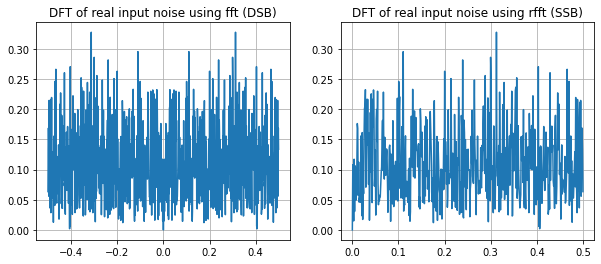

In [21]:
# Show DFT bin levels for real input
# . Sine with A = 1, so power A^2 / 2,  yields phasor in both side bands, each with amplitude
#   A / N_sidebands = 0.5, because both with equal power, such that P_sine = A^2/2. The factor
#   is 1 / N and not 1 / sqrt(N)is because the input sine is coherent.
# . For DC at bin frequency 0 the real input gain is 1.0, because DC has only one phasor
#   component of frequency 0.
# . For white noise the power in each bin is a factor N_fft less, so the std() is 
#   sqrt(N_fft) less, because the white noise is incoherent.
#

# . Input level
ampl = 1.0
sigma = ampl / np.sqrt(2)
sigma = 4

# . DFT size
N_bins = N_fft // 2 + 1  # positive frequency bins including DC and f_s/2

# . select a bin
cw_bin = 200   # carrier wave bin index in range(N_bins)
dc_bin = 0  # DC

# . time and frequency axis
f_s = f_adc  # sample frequency
f_s = 1  # normalized sample frequency
T_s = 1 / f_s  # sample period
T_fft = N_fft * T_s  # DFT period
t_axis = np.linspace(0, T_fft, N_fft, endpoint=False)
f_axis = np.linspace(0, f_s, N_fft, endpoint=False)
f_axis_fft = f_axis - f_s/2  # fftshift axis
f_axis_rfft = f_axis[0:N_bins]  # positive frequency bins

bw_bin = f_s / N_fft  # bin band width
f_bin = cw_bin * bw_bin  # bin frequency

# . create sine at cw_bin and with DC, use cos to create DC at dc_bin = 0  
s = ampl * np.cos(2 * np.pi * f_bin * t_axis)
dc = ampl * np.cos(2 * np.pi * dc_bin * t_axis)  # equivalent to dc = ampl
noise = np.random.randn(N_fft)
noise *= sigma / np.std(noise)  # apply requested sigma
noise -= np.mean(noise)  # apply zero mean to have std = rms for input
b = ampl * np.sign(s)  # block wave, sign: -1 if x < 0, 0 if x==0, 1 if x > 0

x = s + dc
y = noise
mean_y = np.mean(y)
sigma_y = np.std(y)

noise_complex = np.random.randn(N_fft) + np.random.randn(N_fft) * 1j
noise_complex *= sigma / np.std(noise_complex)  # apply requested sigma
noise_complex -= np.mean(noise_complex)  # apply zero mean to have std = rms for input
z = noise_complex
mean_z = np.mean(z)
sigma_z = np.std(z)

print(f"ampl = {ampl}")
print(f"sigma = {sigma}")
print(f"sigma_y = {sigma_y:.6f}")
print(f"sigma_z = {sigma_z:.6f}")
print(f"mean_y = {mean_y:.6f}")
print(f"mean_z = {mean_z:.6f}")
print()

# . DFT using complex input fft()
S_fft = np.fft.fftshift(np.fft.fft(s) / N_fft)
B_fft = np.fft.fftshift(np.fft.fft(b) / N_fft)
X_fft = np.fft.fftshift(np.fft.fft(x) / N_fft)
Y_fft = np.fft.fftshift(np.fft.fft(y) / N_fft)
Z_fft = np.fft.fftshift(np.fft.fft(z) / N_fft)

# . DFT using real input rfft()
S_rfft = np.fft.rfft(s) / N_fft
B_rfft = np.fft.rfft(b) / N_fft
X_rfft = np.fft.rfft(x) / N_fft
Y_rfft = np.fft.rfft(y) / N_fft

# Plot sine spectrum
# . DSB = double sideband
# . SSB = single sideband (= DC + positive frequencies)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('DFT of real input sine using fft (DSB)')
plt.plot(f_axis_fft, abs(X_fft))
plt.grid()
plt.subplot(1, 2, 2)
plt.title('DFT of real input sine using rfft (SSB)')
plt.plot(f_axis_rfft, abs(X_rfft))
plt.grid()
plt.savefig('plots/lofar2_station_sdp_firmware_model_sine_spectrum.jpg', dpi=dpi)

# Plot block spectrum
# . DSB = double sideband
# . SSB = single sideband (= DC + positive frequencies)
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('DFT of real input block using fft (DSB)')
plt.plot(f_axis_fft, abs(B_fft))
plt.grid()
plt.subplot(1, 2, 2)
plt.title('DFT of real input block using rfft (SSB)')
plt.plot(f_axis_rfft, abs(B_rfft))
plt.grid()
plt.savefig('plots/lofar2_station_sdp_firmware_model_block_spectrum.jpg', dpi=dpi)

# Plot real input noise spectrum
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.title('DFT of real input noise using fft (DSB)')
plt.plot(f_axis_fft, abs(Y_fft))
plt.grid()
plt.subplot(1, 2, 2)
plt.title('DFT of real input noise using rfft (SSB)')
plt.plot(f_axis_rfft, abs(Y_rfft))
plt.grid()
plt.savefig('plots/lofar2_station_sdp_firmware_model_noise_spectrum.jpg', dpi=dpi)

print("The DFT of the sine plot shows:")
print(f". G_fft_real_input_dc = {G_fft_real_input_dc}")
print(f". G_fft_real_input_sine = {G_fft_real_input_sine}")
print()

S_max = max(abs(S_rfft)) 
B_max = max(abs(B_rfft)) 
print(f"The DFT of the block plot shows that the first harmonic has an amplitude of 4/pi * A/2 = {B_max}, \
which is larger than A / 2 = {S_max} for sine input. Hence the bin samples need 1 bit more than for a full \
scale sine, because to also fit e.g. this harmonic of a block wave.")
print()

print("The rfft = fft without the negative frequencies.")
print(f". len(Y_fft) = {len(Y_fft)}")
print(f". len(Y_rfft) = {len(Y_rfft)}")
print(f". Y_fft[512-3:512] = \n{Y_fft[512-3:512]}")
print(f". Y_fft[512:512+3] = \n{Y_fft[512:512+3]}")
print(f". Y_rfft[0:3] = \n{Y_rfft[0:3]}")
print()

mean_Y_fft = np.mean(Y_fft)
mean_Y_rfft = np.mean(Y_rfft)
sigma_Y_fft = np.std(Y_fft)
sigma_Y_rfft = np.std(Y_rfft)
rms_Y_fft = np.sqrt(sigma_Y_fft**2 + np.abs(mean_Y_fft)**2)
rms_Y_rfft = np.sqrt(np.sum(np.abs(Y_rfft)**2) / (N_fft // 2 + 1))  # equivalent
rms_Y_rfft = np.sqrt(sigma_Y_rfft**2 + np.abs(mean_Y_rfft)**2)   # equivalent

print(f"For the DFT of the real input noise the expected std() = {sigma_y / np.sqrt(N_fft):.6f}:")
print(f". mean(Y_fft) = {mean_Y_fft:.6f}")
print(f". mean(Y_rfft) = {mean_Y_rfft:.6f}")
print(f". std(Y_fft) = {sigma_Y_fft}")
print(f". std(Y_rfft) = {sigma_Y_rfft}")
print(f". rms(Y_fft) = {rms_Y_fft}")
print(f". rms(Y_rfft) = {rms_Y_rfft}")
print("The slight difference with fft() and rfft() for std() and rms() results is due to that mean_Y_fft \
and mean_Y_rfft are not 0, so rms != std and due to that rfft has length N_fft//2 + 1.")
print()

mean_Z_fft = np.mean(Z_fft)
sigma_Z_fft = np.std(Z_fft)
rms_Z_fft = np.sqrt(np.sum(np.abs(Z_fft)**2) / N_fft)  # equivalent
rms_Z_fft = np.sqrt(sigma_Z_fft**2 + np.abs(mean_Z_fft)**2)  # equivalent
print(f"For the DFT of the complex input noise the expected std() = {sigma_z / np.sqrt(N_fft):.6f}:")
print(f". mean(Z_fft) = {mean_Z_fft}")
print(f". std(Z_fft) = {sigma_Z_fft}")
print(f". rms(Z_fft) = {rms_Z_fft}")


sine ampl = 1.0000
sine sigma = 0.7071 (= 4.0000)
sine power = 0.5000 (= 0.5000)

sine bin ampl = 0.5000
sine bin re = 0.5000
sine bin im = 0.0000
sine bin std = 0.5000
sine bin power = 0.2500
sine all bins power = 0.5000


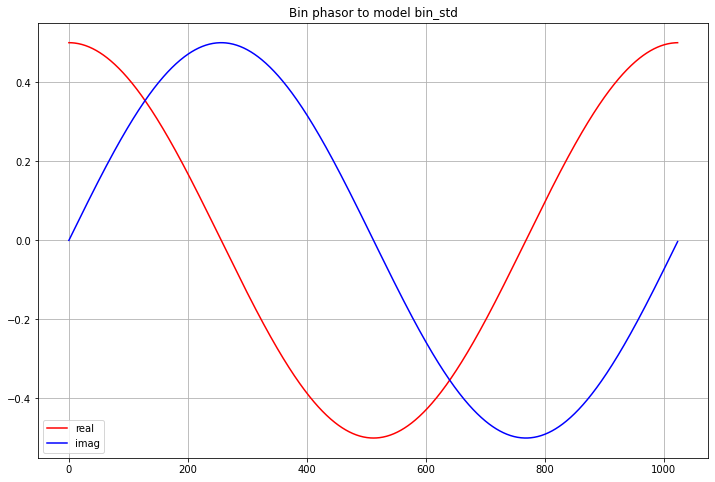

In [25]:
# Log amplitude, sigma and power of the sine bins
# . For sine input the bin is a constant phasor when the sine frequency corresponds to
#   the center of the bin and a rotating phasor when the sine frequency is off center,
#   the phasor then rotates with the delta frequency = bin frequency - sine frequency.
# . The input sine has ampl = A and power A**2 / 2. 
# . The real input results in N_sidebands = 2 bins.
# . The amplitude of the phasor is equal to the std() of a rotating phasor.
# . The amplitude of the bin phasor is A/2, so the bin phasor A/2 exp(jwt) has power
#   (A/2)**2
# . The total power in the N_sidebands = 2 bins is equal to the input power as expected

# . input sine
sin_std = np.std(s)
sine_power = np.sum(s**2) / N_fft
print(f"sine ampl = {ampl:.4f}")
print(f"sine sigma = {sin_std:.4f} (= {sigma:.4f})")
print(f"sine power = {sin_std**2:.4f} (= {sine_power:.4f})")
print()

# . fft bin
bin_ampl = np.max(np.abs(S_rfft))
bin_re = np.max(S_rfft.real)
bin_im = np.max(S_rfft.imag)
bin_power = bin_ampl**2
bins_power = bin_power * N_sidebands

# . Model bin_std using a rotating phasor with bw_bin frequency to have one complete
#   period in t_axis
bin_phasor = bin_ampl * np.exp(2 * np.pi * 1j * bw_bin * t_axis)
bin_std = np.std(bin_phasor)

plt.figure(figsize=(12, 8))
plt.title('Bin phasor to model bin_std')
plt.plot(t_axis, bin_phasor.real, 'r', t_axis, bin_phasor.imag, 'b')
plt.grid()
plt.legend(['real', 'imag'])
plt.savefig('plots/lofar2_station_sdp_firmware_model_bin_phasor.jpg', dpi=dpi)

print(f"sine bin ampl = {bin_ampl:.4f}")
print(f"sine bin re = {bin_re:.4f}")
print(f"sine bin im = {bin_im:.4f}")
print(f"sine bin std = {bin_std:.4f}")
print(f"sine bin power = {bin_power:.4f}")
print(f"sine all bins power = {bins_power:.4f}")


In [23]:
# Log sigma and power of the noise bins (incoherent signal input)

# . real input noise
noise_mean = np.mean(y)
noise_std = np.std(y)
noise_var = noise_std**2
noise_power = np.sum(y**2) / N_fft
print(f"noise mean = {noise_mean:f})")
print(f"noise sigma = {noise_std:f}")
print(f"noise var = {noise_var:f})")
print(f"noise power = {noise_power:f})")
print()

# . fft bin
# . The white noise will appear equally in all bins, therefore the bin_std can
#   be modelled by averaging over all bins. This however does cause small 
#   differences in fft input and output std, due to that fft output mean != 0,
#   so rms != std.
bin_std = np.std(Y_fft)
bin_var = bin_std**2
bin_mean = np.mean(Y_fft)
bin_power = bin_var + np.abs(bin_mean)**2
bins_power = bin_power * N_fft

bin_re_mean = np.mean(Y_fft.real)
bin_re_std = np.std(Y_fft.real)
bin_re_var = bin_re_std**2
bin_re_power = bin_re_var + np.abs(bin_re_mean)**2
bin_im_mean = np.mean(Y_fft.imag)
bin_im_std = np.std(Y_fft.imag)
bin_im_var = bin_im_std**2
bin_im_power = bin_im_var + np.abs(bin_im_mean)**2


print(f"N_fft = {N_fft}")
print(f"sqrt(N_fft) = {np.sqrt(N_fft)}")
print(f"sigma / std(Y_fft) = {sigma / bin_std:f}")
print()
print(f"noise bin std(fft) = {bin_std:f}")
print(f"noise bin power = {bin_power:f}")
print(f"noise bins power = {bins_power:f} (= noise power)")
print()
print(f"noise bin.re std = {bin_re_std:f}")
print(f"noise bin.im std = {bin_im_std:f}")
print(f"noise bin.re power + bin.im power = {bin_re_power + bin_im_power:f} (= bin power)")

print()
print("The ratio of real input noise std and DFT bin noise std shows:")
print(f". G_fft_real_input_noise = {G_fft_real_input_noise} = (1 / sqrt({N_fft}))")

noise mean = -0.000000)
noise sigma = 4.000000
noise var = 16.000000)
noise power = 16.000000)

N_fft = 1024
sqrt(N_fft) = 32.0
sigma / std(Y_fft) = 32.004632

noise bin std(fft) = 0.124982
noise bin power = 0.015625
noise bins power = 16.000000 (= noise power)

noise bin.re std = 0.092081
noise bin.im std = 0.084508
noise bin.re power + bin.im power = 0.015625 (= bin power)

The ratio of real input noise std and DFT bin noise std shows:
. G_fft_real_input_noise = 0.03125 = (1 / sqrt(1024))


Conclusion:
* For coherent sine input is easiest to calculate power via the amplitude of the single bin phasor
* For incoherent white noise input is easiest to calculate power via the std of all bins, but this is an approximation because the mean of the input and the output bins will typically not be exactly 0.